In [ ]:
import argparse
import sys
from pathlib import Path
from typing import List, Sequence, Tuple
import warnings

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm.notebook import tqdm  # Use notebook version of tqdm

# ==========================================
# PART 1: FEATURES (From features.py)
# ==========================================

def _skin_mask(frame: np.ndarray) -> np.ndarray:
    """Return a binary mask that keeps typical skin tones in HSV space."""
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower1 = np.array([0, 30, 60], dtype=np.uint8)
    upper1 = np.array([20, 150, 255], dtype=np.uint8)
    lower2 = np.array([170, 30, 60], dtype=np.uint8)
    upper2 = np.array([180, 150, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower1, upper1) | cv2.inRange(hsv, lower2, upper2)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=1)
    mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=2)
    return mask

def preprocess_hand_roi(frame: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    """Apply skin masking + normalization before feature extraction."""
    if frame is None:
        raise ValueError("Received empty frame for preprocessing")

    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    
    # NOTE: The Kaggle dataset is already cropped. 
    # Sometimes strict skin masking kills the image if lighting is off.
    # We add a fallback check.
    mask = _skin_mask(blurred)
    if cv2.countNonZero(mask) == 0:
        # Fallback: Use the whole image if mask fails
        foreground = blurred
    else:
        foreground = cv2.bitwise_and(blurred, blurred, mask=mask)
        
    gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
    return resized

def hog_descriptor(gray: np.ndarray) -> np.ndarray:
    """Compute a HOG descriptor from a grayscale ROI."""
    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True,
    )
    return features.astype(np.float32)

def hu_moments(gray: np.ndarray) -> np.ndarray:
    """Return log-transformed Hu moments for global shape cues."""
    moments = cv2.HuMoments(cv2.moments(gray)).flatten()
    # Log transform to make the scale manageable
    safe = np.where(moments == 0, 1e-12, moments)
    logged = -np.sign(safe) * np.log10(np.abs(safe))
    return logged.astype(np.float32)

def color_histogram(frame: np.ndarray) -> np.ndarray:
    """HSV histogram that captures coarse color distribution."""
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 4, 4], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None).flatten()
    return hist.astype(np.float32)

def extract_feature_vector(frame: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    """Fuse HOG, Hu moments, and HSV histograms into a single vector."""
    roi = preprocess_hand_roi(frame, target_size)
    hog_vec = hog_descriptor(roi)
    hu_vec = hu_moments(roi)
    color_vec = color_histogram(frame)
    return np.concatenate([hog_vec, hu_vec, color_vec])

# ==========================================
# PART 2: TRAINING & UTILS (Modified train.py)
# ==========================================

IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

def collect_samples(data_dir: Path, limit_per_class: int | None) -> List[Tuple[Path, str]]:
    if not data_dir.exists():
        raise FileNotFoundError(f"Dataset directory '{data_dir}' was not found.")

    samples: List[Tuple[Path, str]] = []
    # Iterate over class directories
    for class_dir in sorted(p for p in data_dir.iterdir() if p.is_dir()):
        image_paths = [p for p in class_dir.iterdir() if p.suffix.lower() in IMAGE_EXTS]
        image_paths.sort()
        
        if limit_per_class:
            image_paths = image_paths[:limit_per_class]
            
        samples.extend((img_path, class_dir.name) for img_path in image_paths)
    
    if not samples:
        raise RuntimeError(f"No images discovered under {data_dir}")
    
    print(f"Found {len(samples)} images across {len(set(s[1] for s in samples))} classes.")
    return samples

def load_features(samples, img_size):
    class_names = sorted({label for _, label in samples})
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    features: List[np.ndarray] = []
    labels: List[int] = []
    
    print("Extracting Features (HOG + Hu + Color Hist)...")
    for img_path, label in tqdm(samples):
        frame = cv2.imread(str(img_path))
        if frame is None:
            continue
        try:
            feat_vec = extract_feature_vector(frame, img_size)
            features.append(feat_vec)
            labels.append(class_to_idx[label])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    X = np.vstack(features).astype(np.float32)
    y = np.array(labels, dtype=np.int32)
    return X, y, class_names

def build_classifier(model_name: str, seed: int) -> Pipeline:
    scaler = StandardScaler()
    if model_name == "svm":
        # Probability=True slows down SVM significantly. 
        # Set to False if you don't need predict_proba, or use a smaller dataset.
        print("Initializing SVM (This may take time)...")
        estimator = SVC(C=10.0, gamma="scale", kernel="rbf", random_state=seed)
    elif model_name == "rf":
        print("Initializing Random Forest...")
        estimator = RandomForestClassifier(
            n_estimators=200, max_depth=None, n_jobs=-1, random_state=seed
        )
    elif model_name == "knn":
        print("Initializing KNN...")
        estimator = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
    else:
        raise ValueError(f"Unsupported model '{model_name}'")
    return Pipeline([("scaler", scaler), ("clf", estimator)])

def plot_confusion_matrix_heatmap(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# ==========================================
# PART 3: MAIN EXECUTION BLOCK
# ==========================================

# CONFIGURATION
# ------------------------------------------
# CHANGE THIS PATH based on your environment
# For Colab (after unzip): 'data/asl_alphabet_train/asl_alphabet_train'
# For Kaggle: '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
DATA_DIR = Path('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train') 

MODEL_TYPE = "rf"      # Options: 'svm', 'rf' (RandomForest), 'knn'
IMG_SIZE = (64, 64)    # Smaller size = faster HOG calculation
LIMIT_SAMPLES = 300    # Samples per class. Total dataset is huge (87k). 
                       # Start with 300 per class (29 * 300 = 8700 images) for quick testing.
                       # Increase to None to use full dataset (will take hours).
VAL_SPLIT = 0.2
SEED = 42

# 1. Collect Data
print(f"Scanning {DATA_DIR}...")
try:
    samples = collect_samples(DATA_DIR, LIMIT_SAMPLES)
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please check the DATA_DIR path in the configuration section.")
    sys.exit(1)

# 2. Extract Features
X, y, class_names = load_features(samples, IMG_SIZE)
print(f"Feature Matrix Shape: {X.shape}")

# 3. Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SPLIT, stratify=y, random_state=SEED
)

# 4. Train
print(f"Training {MODEL_TYPE} classifier...")
clf = build_classifier(MODEL_TYPE, SEED)
clf.fit(X_train, y_train)

# 5. Evaluate
print("\nEvaluating on Validation Set...")
preds = clf.predict(X_val)
acc = accuracy_score(y_val, preds)

print(f"\n============================================")
print(f" Final Validation Accuracy: {acc:.4f}")
print(f"============================================")

print("\nClassification Report:")
print(classification_report(
    y_val, 
    preds, 
    target_names=class_names,
    digits=4
))

# 6. Visualizations
print("Generating Confusion Matrix...")
plot_confusion_matrix_heatmap(y_val, preds, class_names)

# Save model
model_out = Path("models/classical_asl_model.joblib")
model_out.parent.mkdir(parents=True, exist_ok=True)
dump({"model": clf, "class_names": class_names}, model_out)
print(f"Model saved to {model_out}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

# ========================================================
# 1. FIXING THE CONFUSION MATRIX (With Numbers)
# ========================================================
def plot_cm_with_numbers(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    # Increase figure size to accommodate 29 classes
    plt.figure(figsize=(20, 18)) 
    
    sns.heatmap(
        cm, 
        annot=True,         # <--- THIS puts the numbers in
        fmt='d',            # <--- Ensures numbers are integers (not scientific notation)
        cmap='Blues', 
        xticklabels=classes, 
        yticklabels=classes,
        cbar=False          # Remove color bar to save space
    )
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title('Confusion Matrix (with Counts)', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

print("Generating detailed Confusion Matrix...")
plot_cm_with_numbers(y_val, preds, class_names)


# ========================================================
# 2. THE "TRAINING GRAPH" EQUIVALENT: LEARNING CURVE
# ========================================================
# This checks if adding more data improves the model.
# WARNING: This might take 1-2 minutes to run as it retrains the model 5 times.

def plot_learning_curve(estimator, X, y):
    print("\nComputing Learning Curve (this retrains the model on subsets)...")
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, 
        X, 
        y, 
        cv=3,                   # 3-fold cross-validation
        n_jobs=-1,              # Use all CPU cores
        train_sizes=np.linspace(0.1, 1.0, 5), # 10%, 32%, 55%, 77%, 100% of data
        scoring='accuracy'
    )

    # Calculate means and std deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(12, 6))
    
    # Plot Training Accuracy
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    
    # Plot Validation Accuracy
    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

    plt.title("Learning Curve (Classical Model)", fontsize=16)
    plt.xlabel("Number of Training Samples", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Run the learning curve
plot_learning_curve(clf, X_train, y_train)


# ========================================================
# 3. PER-CLASS ACCURACY BAR CHART
# ========================================================
# This visualizes exactly which letters are failing.

def plot_per_class_accuracy(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    # Extract F1-scores for each class (ignoring 'accuracy', 'macro avg', etc.)
    class_scores = {k: v['f1-score'] for k, v in report.items() if k in classes}
    
    df = pd.DataFrame(list(class_scores.items()), columns=['Class', 'F1-Score'])
    
    plt.figure(figsize=(16, 6))
    sns.barplot(x='Class', y='F1-Score', data=df, palette='viridis')
    plt.title("Model Performance by Class (F1-Score)", fontsize=16)
    plt.ylim(0, 1.1) # Scale from 0 to 1
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Good Performance Threshold')
    plt.legend()
    plt.show()

print("Generating Per-Class Performance Graph...")
plot_per_class_accuracy(y_val, preds, class_names)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import load

# ==========================================
# CONFIGURATION
# ==========================================
# The folder we just downloaded
TEST_DIR = Path('/kaggle/input/testingdata') 
MODEL_PATH = Path("/kaggle/working/models/classical_asl_model.joblib")

# ==========================================
# LOAD MODEL & UTILS
# ==========================================
# We need to make sure the feature extraction functions exist.
# (Assuming you ran the previous training cells in this session)
if not MODEL_PATH.exists():
    print(f"CRITICAL ERROR: Model file not found at {MODEL_PATH}")
    print("Please run the TRAINING code block first so the model is saved.")
else:
    print(f"Loading model from {MODEL_PATH}...")
    data = load(MODEL_PATH)
    clf = data["model"]
    class_names = data["class_names"]
    img_size = data.get("img_size", (64, 64))

# ==========================================
# THE TESTING LOOP
# ==========================================
def test_custom_images(test_dir):
    image_paths = sorted([p for p in test_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])
    
    if not image_paths:
        print("No images found! Check Step 1.")
        return

    print(f"Testing on {len(image_paths)} new images...")
    
    # Setup grid for plotting
    cols = 4
    rows = (len(image_paths) // cols) + 1
    plt.figure(figsize=(16, 4 * rows))
    
    correct_count = 0
    
    for i, img_path in enumerate(image_paths):
        # 1. Parse True Label (Assumes filename like "A_test1.jpg")
        filename = img_path.stem
        true_label = filename.split('_')[0].upper() 
        
        # 2. Read Image
        frame = cv2.imread(str(img_path))
        if frame is None: continue

        # 3. Preprocess & Predict
        try:
            # Use the exact same feature extractor used in training
            features = extract_feature_vector(frame, img_size)
            
            # Predict
            pred_idx = clf.predict([features])[0]
            predicted_label = class_names[pred_idx]
            
            # Get Confidence (Probability) if available
            probs = clf.predict_proba([features])[0]
            confidence = np.max(probs) * 100
            
            # 4. Visualization Logic
            is_correct = (predicted_label == true_label)
            if is_correct: correct_count += 1
            
            # Plot
            ax = plt.subplot(rows, cols, i + 1)
            
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            ax.imshow(frame_rgb)
            
            # Color code the title: Green = Right, Red = Wrong
            title_color = 'green' if is_correct else 'red'
            title_text = f"True: {true_label} | Pred: {predicted_label}\nConf: {confidence:.1f}%"
            
            ax.set_title(title_text, color=title_color, fontweight='bold', fontsize=12)
            ax.axis('off')
            
        except Exception as e:
            print(f"Error on {filename}: {e}")

    plt.tight_layout()
    plt.show()
    
    print("="*40)
    print(f"REAL WORLD ACCURACY: {correct_count}/{len(image_paths)} ({(correct_count/len(image_paths))*100:.1f}%)")
    print("="*40)

# Run it
if 'clf' in locals():
    test_custom_images(TEST_DIR)
else:
    print("Model 'clf' not found in memory. Please run the training cell first!")

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

# 1. Load one of your test images
test_img_path = '/kaggle/input/testingdata/A_test1.jpg'  # Make sure this path is correct
frame = cv2.imread(test_img_path)

# 2. Generate the visualizations
# A. The Skin Mask
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
mask = _skin_mask(blurred)

# B. The HOG Image (What the model "sees")
# We need to resize to match training size (64x64) to generate the HOG vis
resized_gray = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (64, 64))
_, hog_image = hog(
    resized_gray, 
    orientations=9, 
    pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), 
    visualize=True,
    block_norm="L2-Hys"
)

# 3. Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Skin Mask (Is the hand visible?)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features (Notice the background!)")
plt.axis('off')

plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def smart_crop_and_mask(frame):
    """
    1. Detects skin.
    2. Finds the largest skin blob (The Hand).
    3. Crops the image to zoom in on that blob.
    """
    # 1. Blur & Skin Mask (The same as before)
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    
    # Adjusting the values slightly to be stricter on "Door" colors if possible, 
    # but sticking to standard ranges for now.
    lower1 = np.array([0, 30, 60], dtype=np.uint8)
    upper1 = np.array([20, 150, 255], dtype=np.uint8)
    lower2 = np.array([170, 30, 60], dtype=np.uint8)
    upper2 = np.array([180, 150, 255], dtype=np.uint8)
    
    mask = cv2.inRange(hsv, lower1, upper1) | cv2.inRange(hsv, lower2, upper2)
    
    # Clean up noise
    mask = cv2.medianBlur(mask, 5)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=2)
    
    # 2. Find Contours (Blobs)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return frame, mask # Fallback if no skin found
        
    # 3. Get the Largest Blob (Assuming the hand is the main subject)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # 4. Get Bounding Box around the hand
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add a little padding so we don't cut off fingertips
    padding = 20
    h_img, w_img = frame.shape[:2]
    
    x1 = max(0, x - padding)
    y1 = max(0, y - padding)
    x2 = min(w_img, x + w + padding)
    y2 = min(h_img, y + h + padding)
    
    # Crop!
    cropped_frame = frame[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]
    
    return cropped_frame, cropped_mask

# ==========================================
# TEST THE FIX
# ==========================================
img_path = '/kaggle/input/testingdata/A_test1.jpg' # Use your file path
original = cv2.imread(img_path)

if original is not None:
    cropped, mask = smart_crop_and_mask(original)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(f"Original (With Door)\nSize: {original.shape[:2]}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f"Smart Cropped (Just Hand)\nSize: {cropped.shape[:2]}")
    
    plt.show()
    
    # Quick Prediction Check if model is loaded
    if 'clf' in locals():
        # We need to resize the crop to 64x64 for the model
        features = extract_feature_vector(cropped, (64, 64))
        pred = clf.predict([features])[0]
        name = class_names[pred]
        print(f"\nPrediction on Cropped Image: {name}")
    else:
        print("Model not loaded.")

Processing 56 images with Smart Crop...
Saving results to test_results_grid.png ...


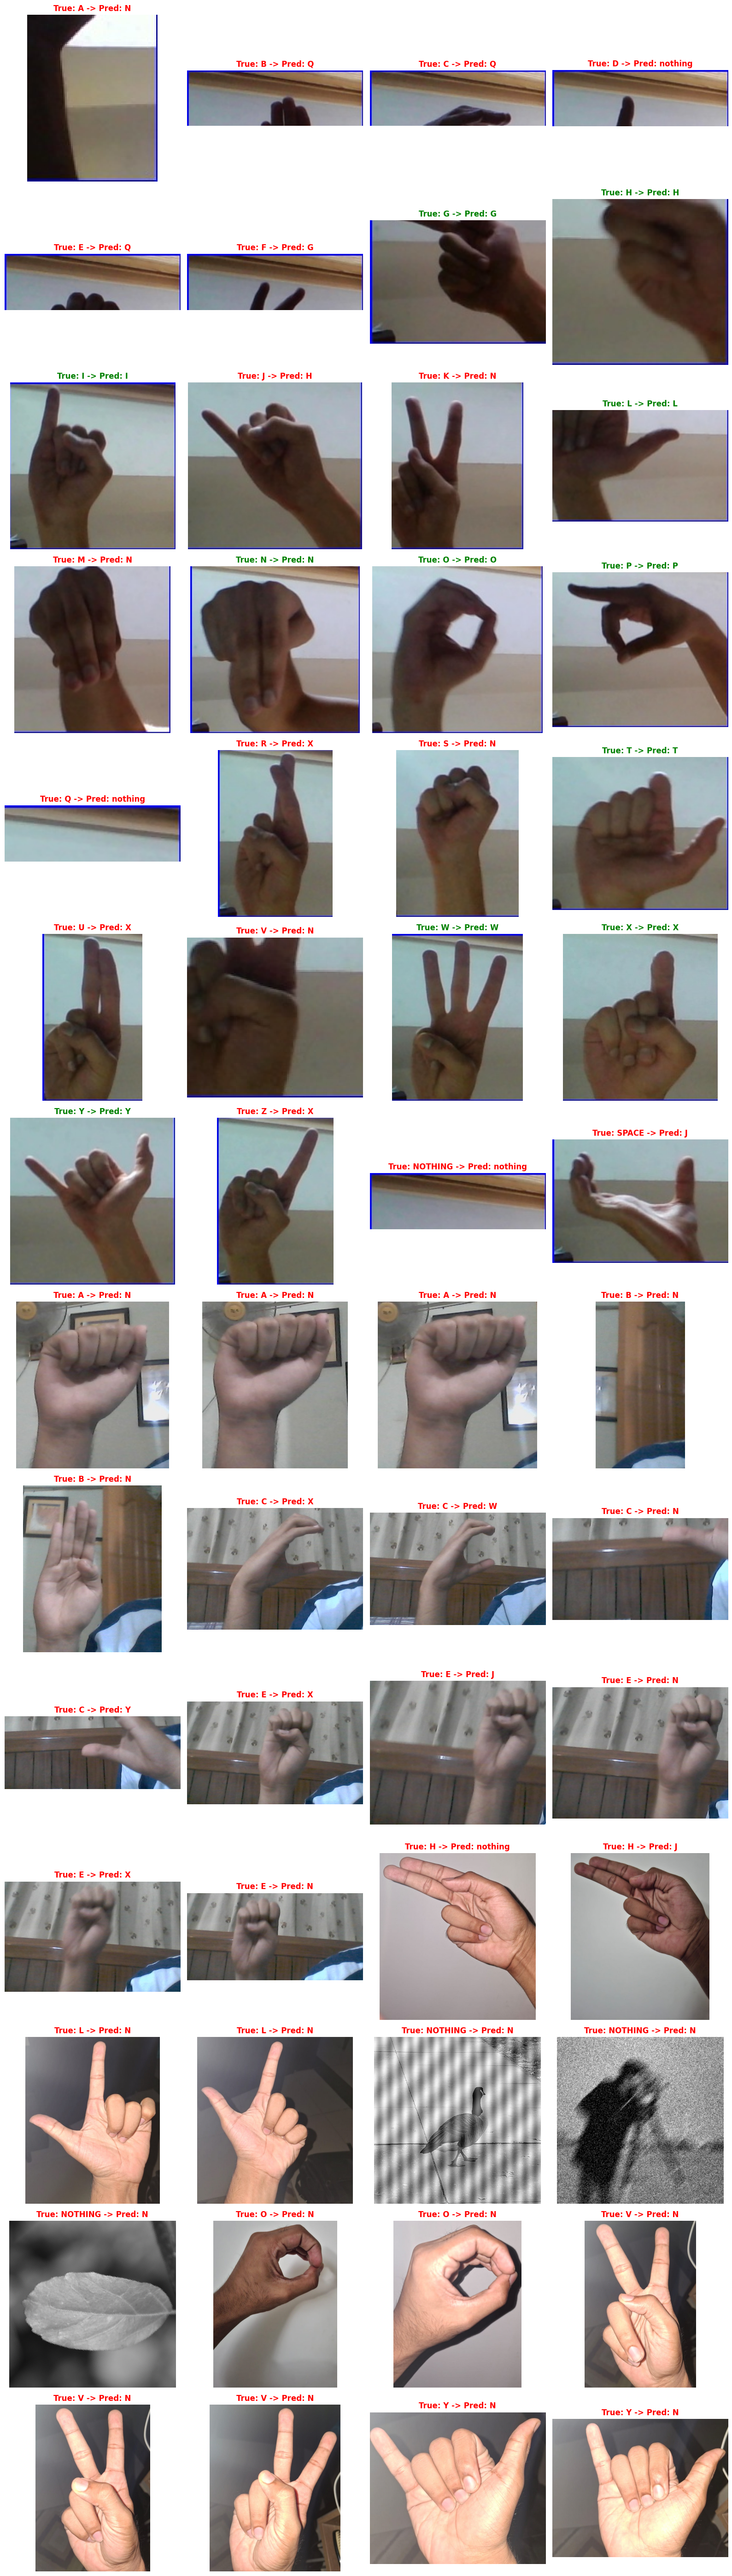

SMART CROP ACCURACY: 11/56 (19.6%)


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import load

# ==========================================
# 1. RE-DEFINE SMART CROP (To ensure it's in memory)
# ==========================================
def smart_crop_and_mask(frame):
    # Blur & HSV
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    
    # Standard Skin HSV
    lower1 = np.array([0, 30, 60], dtype=np.uint8)
    upper1 = np.array([20, 150, 255], dtype=np.uint8)
    lower2 = np.array([170, 30, 60], dtype=np.uint8)
    upper2 = np.array([180, 150, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower1, upper1) | cv2.inRange(hsv, lower2, upper2)
    
    # Clean noise
    mask = cv2.medianBlur(mask, 5)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no skin, return original
    if not contours:
        return frame
        
    # Pick largest blob (Hand)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Pad and Crop
    padding = 20
    h_img, w_img = frame.shape[:2]
    x1, y1 = max(0, x - padding), max(0, y - padding)
    x2, y2 = min(w_img, x + w + padding), min(h_img, y + h + padding)
    
    return frame[y1:y2, x1:x2]

# ==========================================
# 2. RUN ON ALL IMAGES
# ==========================================
TEST_DIR = Path('/kaggle/input/testingdata')
TEST_DIR2 = Path('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test')

MODEL_PATH = Path("models/classical_asl_model.joblib")

if not MODEL_PATH.exists():
    print("Model not found! Run training first.")
else:
    data = load(MODEL_PATH)
    clf = data["model"]
    class_names = data["class_names"]
    img_size = data.get("img_size", (64, 64))

    image_paths = sorted([p for p in TEST_DIR.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])

    image_paths.extend([p for p in TEST_DIR2.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])

    image_paths = sorted(image_paths)
    
    print(f"Processing {len(image_paths)} images with Smart Crop...")
    
    correct_count = 0
    
    # Grid Setup
    cols = 4
    rows = (len(image_paths) // cols) + 1
    plt.figure(figsize=(16, 4 * rows))

    for i, img_path in enumerate(image_paths):
        # True Label
        filename = img_path.stem
        true_label = filename.split('_')[0].upper()
        
        # Read
        frame = cv2.imread(str(img_path))
        if frame is None: continue
            
        try:
            # --- STEP 1: SMART CROP ---
            cropped = smart_crop_and_mask(frame)
            
            # --- STEP 2: FEATURE EXTRACT ---
            # (Resize is handled inside extract_feature_vector or we do it here)
            # Depending on your previous code, extract_feature_vector likely calls resize.
            # But to be safe, let's pass the cropped image directly.
            features = extract_feature_vector(cropped, img_size)
            
            # --- STEP 3: PREDICT ---
            pred_idx = clf.predict([features])[0]
            predicted_label = class_names[pred_idx]
            
            # Stats
            is_correct = (predicted_label == true_label)
            if is_correct: correct_count += 1
            
            # Plot
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            
            color = 'green' if is_correct else 'red'
            # Show True vs Pred
            ax.set_title(f"True: {true_label} -> Pred: {predicted_label}", color=color, fontweight='bold')
            ax.axis('off')
            
        except Exception as e:
            print(f"Error on {filename}: {e}")

    save_path = "test_results_grid.png"
    print(f"Saving results to {save_path} ...")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

    print("="*40)
    print(f"SMART CROP ACCURACY: {correct_count}/{len(image_paths)} ({(correct_count/len(image_paths))*100:.1f}%)")
    print("="*40)